In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import deque
%matplotlib inline

cal_dir_path = r"E:\GitHub\Udacity\CarND-Advanced-Lane-Lines\camera_cal"
test_dir_path = r"E:\GitHub\Udacity\CarND-Advanced-Lane-Lines\test_images"

In [2]:
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


for img in os.listdir(cal_dir_path):
    if img.endswith(".jpg"):
        file_path = os.path.join(cal_dir_path, img)
        image = cv2.imread(file_path)
        #Convert to grayscale
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            # Draw and display the corners
            #cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            #plt.imshow(image)
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print("Corners not found: %s!" % img)
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Corners not found: calibration1.jpg!
Corners not found: calibration4.jpg!
Corners not found: calibration5.jpg!


(-0.5, 1279.5, 719.5, -0.5)

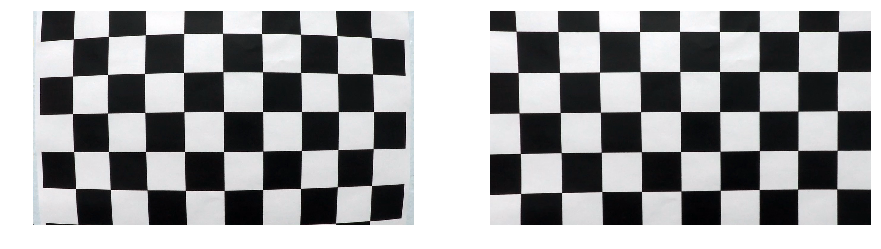

In [3]:
file_path = os.path.join(cal_dir_path, "calibration1.jpg")
image = cv2.imread(file_path)
image_undistorted = cv2.undistort(image, cameraMatrix, distortionCoeffs, None, cameraMatrix)
fig = plt.figure(figsize=(15, 8))
fig.add_subplot(1,2, 1)
plt.imshow(image)
plt.axis('off')
fig.add_subplot(1,2, 2)
plt.imshow(image_undistorted)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

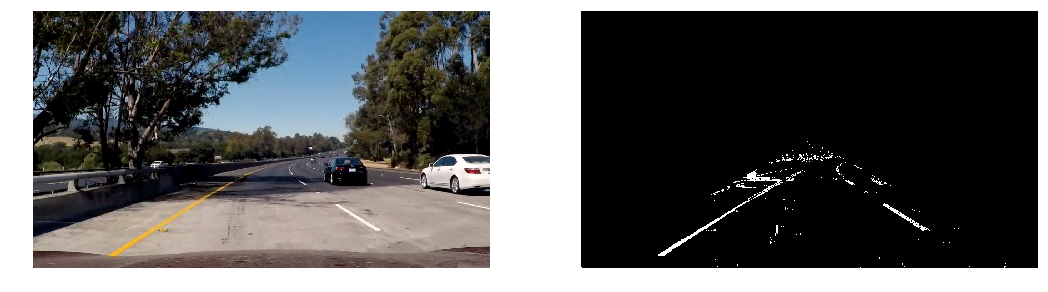

In [4]:
def binary_threshold_transform(image):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # apply the region of interest mask
    mask = np.zeros_like(combined_binary)
    region_of_interest = np.array([[0,height-1], [width/2, height/2], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest], 1)
    combined_binary = cv2.bitwise_and(combined_binary, mask)
    return combined_binary

file_path = os.path.join(test_dir_path, "test5.jpg")
image = mpimg.imread(file_path)
combined_binary = binary_threshold_transform(image)
fig = plt.figure(figsize=(18, 10))
fig.add_subplot(1,2, 1)
plt.imshow(image)
plt.axis('off')
fig.add_subplot(1,2, 2)
plt.imshow(combined_binary, cmap='gray')
plt.axis('off')

# Perspective Transform

I extracted the source vertices manually from a test image to perform perspective transform. Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.

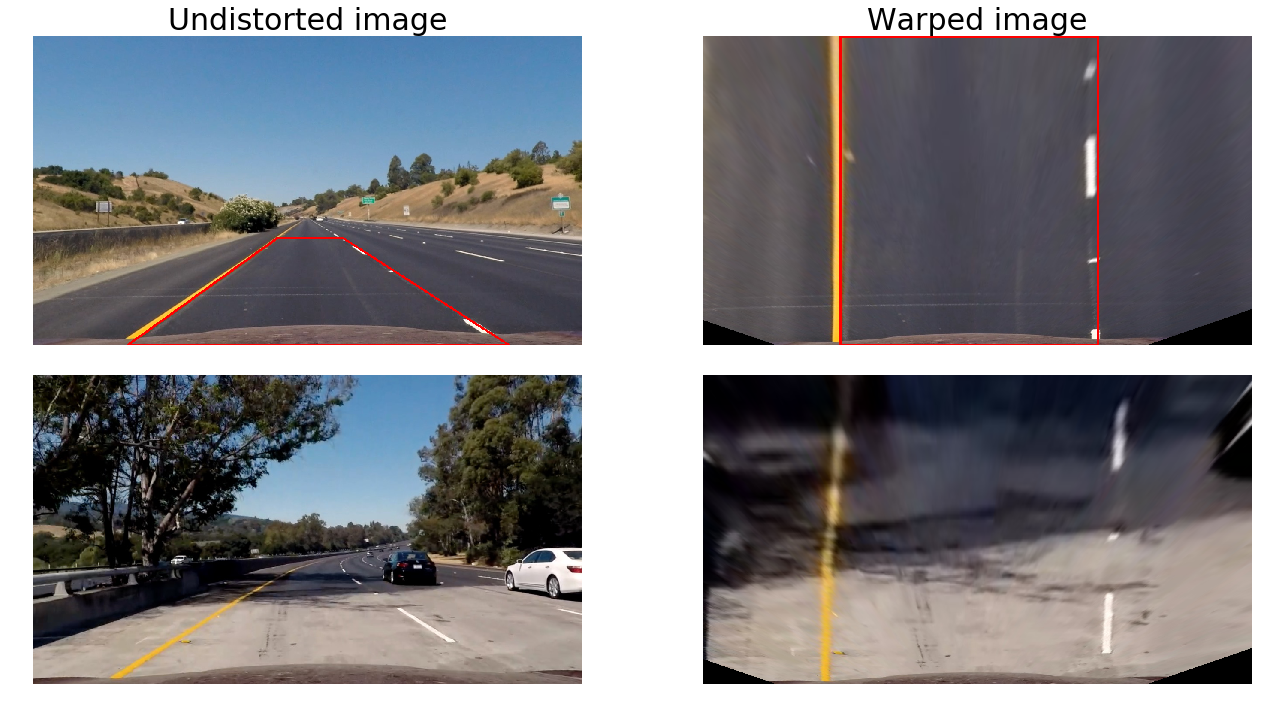

In [5]:
# Vertices extracted manually for performing a perspective transform
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

# Destination points are chosen to make lanes parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

# transform matrices
dst = np.float32([bottom_left,bottom_right,top_right,top_left])
perspective_trans = cv2.getPerspectiveTransform(source, dst)
inv_perspective_trans = cv2.getPerspectiveTransform(dst, source)

# load images
file_path = os.path.join(test_dir_path, "straight_lines1.jpg")
image = mpimg.imread(file_path)
image = cv2.undistort(image, cameraMatrix, distortionCoeffs, None, cameraMatrix)
img_size = (image.shape[1], image.shape[0])

pts = np.array(source, np.int32).reshape((-1,1,2))
image_with_source = image.copy()
cv2.polylines(image_with_source, [pts], isClosed=True, color=(255,0,0), thickness=3)

# transform
warped = cv2.warpPerspective(image, perspective_trans, img_size , flags=cv2.INTER_LINEAR)
pts = np.array(dst, np.int32).reshape((-1,1,2))
cv2.polylines(warped, [pts], isClosed=True, color=(255,0,0), thickness=3)

# image 2
file_path = os.path.join(test_dir_path, "test5.jpg")
image2 = mpimg.imread(file_path)
image2 = cv2.undistort(image2, cameraMatrix, distortionCoeffs, None, cameraMatrix)
img_size = (image2.shape[1], image2.shape[0])
warped2 = cv2.warpPerspective(image2, perspective_trans, img_size , flags=cv2.INTER_LINEAR)
    
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 10))
f.tight_layout()
ax1.imshow(image_with_source)
ax1.set_title('Undistorted image', fontsize=30)
ax1.axis('off')
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped image', fontsize=30)
ax2.axis('off')
ax3.imshow(image2)
ax3.axis('off')
ax4.imshow(warped2, cmap='gray')
ax4.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Sliding Window for Searching Lanes

Sliding window search is performed to find lanes. 

E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0.0, 1280.0, 720.0, 0.0)

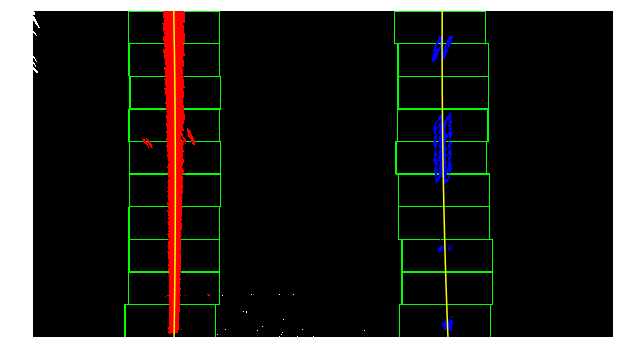

In [6]:
def sliding_window_search(binary_warped):
    # number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return (leftx, lefty), left_fit, (rightx, righty), right_fit, out_img

# load image and transform
file_path = os.path.join(test_dir_path, "straight_lines1.jpg")
image = mpimg.imread(file_path)
image = cv2.undistort(image, cameraMatrix, distortionCoeffs, None, cameraMatrix)
binary = binary_threshold_transform(image)
binary_warped = cv2.warpPerspective(binary, perspective_trans, img_size , flags=cv2.INTER_LINEAR)
# sliding window searching
left_lane, left_fit, right_lane, right_fit, out_img = sliding_window_search(binary_warped)

# Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[left_lane[1], left_lane[0]] = [255, 0, 0]
out_img[right_lane[1], right_lane[0]] = [0, 0, 255]
fig = plt.figure(figsize=(12, 6))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, binary_warped.shape[1])
plt.ylim(binary_warped.shape[0],0)
plt.axis('off')

# Searching around a previously detected line.

Because consecutive frames have lane lines in similar positions, we can search around a margin of 50 pixels of the previously detected lane lines.

(720, 0)

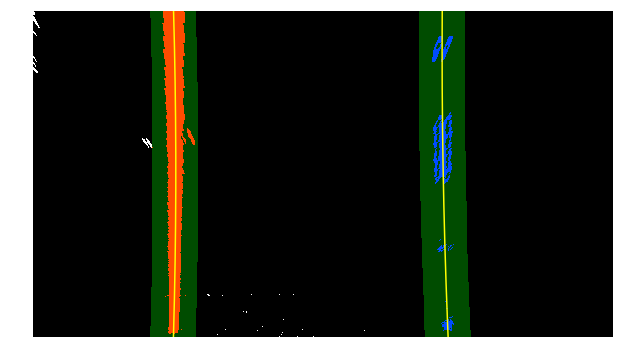

In [7]:
margin = 50

def search_lane_in_margin(binary_warped, left_fit, right_fit):
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) \
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) \
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return (leftx, lefty), left_fit, (rightx, righty), right_fit

left_lane, left_fit, right_lane, right_fit = search_lane_in_margin(binary_warped, left_fit, right_fit)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[left_lane[1], left_lane[0]] = [255, 0, 0]
out_img[right_lane[1], right_lane[0]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
fig = plt.figure(figsize=(12, 6))
plt.imshow(result)
plt.axis('off')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [8]:
def get_curvature_and_offset(leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # compute the offset from the center
    lane_center = (rightx[-1] + leftx[-1])/2
    center_offset_pixels = abs(binary_warped.shape[1]/2 - lane_center)
    center_offset_meter = xm_per_pix*center_offset_pixels
    return (left_curverad, right_curverad, center_offset_meter)

result = get_curvature_and_offset(left_fitx, right_fitx)
print("Radius=%.3f m\nOffset=%.3f m" % ((result[0]+result[1])/2., result[2]))

Radius=4535.286 m
Offset=0.146 m


# Inverse Transform

Paint the lane area and then perform an inverse perspective transform.

(-0.5, 1279.5, 719.5, -0.5)

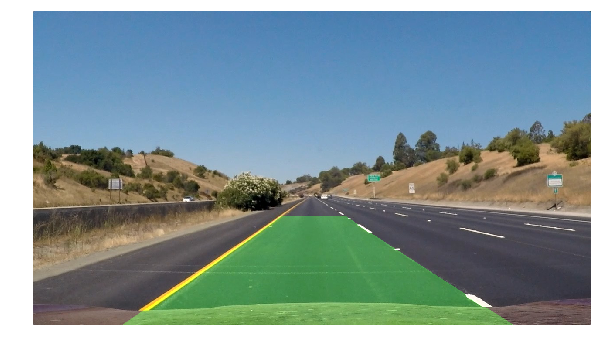

In [9]:
def inverse_transform(image, leftx, rightx):
    img_size = (image.shape[1], image.shape[0])
    #Create an image to draw the lines on
    out_img = np.zeros(image.shape, dtype=np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array(np.transpose(np.vstack([leftx, ploty])))
    pts_right = np.array(np.flipud(np.transpose(np.vstack([rightx, ploty]))))
    pts = np.vstack((pts_left, pts_right))
    # Draw the lane onto the blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))
    unwarped = cv2.warpPerspective(out_img, inv_perspective_trans, img_size , flags=cv2.INTER_LINEAR)
    return cv2.addWeighted(image, 1, unwarped, 0.3, 0)

file_path = os.path.join(test_dir_path, "straight_lines1.jpg")
image = mpimg.imread(file_path)
fig = plt.figure(figsize=(10, 6))
plt.imshow(inverse_transform(image, left_fitx, right_fitx))
plt.axis('off')

# Pipeline

## Figuring out bad frames
There are some frames where lanes cannot be detected correctly. Bad frames are identified if calculated curvatures of left and right lanes are too different. In case of bad frame, we use calculated results from last frame.

## Averaging lanes

The lane curvature for each frame is an average of 10 previously computed lanes.

In [10]:
class Line(object):
    def __init__(self):
        self.video_processing = False 
        self.left_fit = None
        self.right_fit = None
        self.old_results = deque(maxlen=10)

def pipeline(img):
    global lane_info
    
    image = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    binary = binary_threshold_transform(image)
    binary_warped = cv2.warpPerspective(binary, perspective_trans, img_size , flags=cv2.INTER_LINEAR)
    if (not lane_info.video_processing) or (lane_info.left_fit is None):
        left_lane, left_fit, right_lane, right_fit, out_img = sliding_window_search(binary_warped)
    else:
        left_lane, left_fit, right_lane, right_fit = \
            search_lane_in_margin(binary_warped, lane_info.left_fit, lane_info.right_fit)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    result = get_curvature_and_offset(left_fitx, right_fitx)
    ratio = result[1] / result[0]
    if ratio < 1.3 or ratio > 0.8:
        # Good frame
        result = ((result[0]+result[1])/2., result[2])
        lane_info.left_fit = left_fit
        lane_info.right_fit = right_fit
    else:
        # Bad frame, then use results of last frame
        result = lane_info.old_results[-1]
        left_fit = lane_info.left_fit 
        right_fit = lane_info.right_fit 
    lane_info.old_results.append(result)
    if lane_info.video_processing:
        # calculate averaged radius and offset
        result = np.average(lane_info.old_results, axis=0)
    info_string = "Radius=%d m, Offset=%.3f m" % (result[0], result[1])
    final_img = inverse_transform(image, left_fitx, right_fitx)
    cv2.putText(final_img, info_string, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), thickness=2)
    return final_img

(-0.5, 1279.5, 719.5, -0.5)

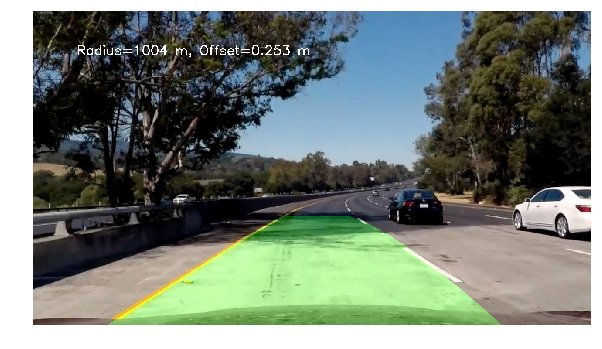

In [14]:
# Test pipeline on an image
lane_info = Line()
file_path = os.path.join(test_dir_path, "test5.jpg")
image = mpimg.imread(file_path)
fig = plt.figure(figsize=(10, 6))
plt.imshow(pipeline(image))
plt.axis("off")

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time

lane_info = Line()
lane_info.video_processing = True
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:59<00:00,  6.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 1s
